# COMP9418 - Assignment 1 - Bayesian Networks as Classifiers

## UNSW Sydney, October 2020

- Qiwen Zheng - z5240149
- Hang Zhu    - z5233612

## Instructions

**Submission deadline:** Sunday, 18th October 2020, at 18:00:00.

**Late Submission Policy:** The penalty is set at 20% per late day. This is ceiling penalty, so if a group is marked 60/100 and they submitted two days late, they still get 60/100.

**Form of Submission:** This is a group assignment. Each group can have up to **two** students. **Only one member of the group should submit the assignment**.

You can reuse any piece of source code developed in the tutorials.

Submit your files using give. On a CSE Linux machine, type the following on the command-line:

``$ give cs9418 ass1 solution.zip``

Alternative, you can submit your solution via the [WebCMS](https://webcms3.cse.unsw.edu.au/COMP9418/20T3).

## Technical prerequisites

These are the libraries your are allowed to use. No other libraries will be accepted.

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import math
from itertools import product, combinations
from collections import OrderedDict as odict
from graphviz import Digraph
from tabulate import tabulate

## Initial task - Initialise graph

Create a graph ``G`` that represents the following network by filling in the edge lists.
![Bayes Net](BayesNet.png)


In [3]:
G = {
    "BreastDensity" : ["Mass"],
    "Location" : ["BC"],
    "Age" : ["BC"],
    "BC" : ["Metastasis","MC","SkinRetract","NippleDischarge","AD","Mass"],
    "Mass" : ["Size","Shape","Margin"],
    "AD" : ["FibrTissueDev"],
    "Metastasis" : [ "LymphNodes"],
    "MC" : [],
    "Size" : [],
    "Shape" : [],
    "FibrTissueDev" : ["SkinRetract","NippleDischarge","Spiculation"],
    "LymphNodes" : [],
    "SkinRetract" : [],
    "NippleDischarge" : [],
    "Spiculation" : ["Margin"],
    "Margin" : [],
}


## [20 Marks] Task 1 - Efficient d-separation test

Implement the efficient version of the d-separation algorithm in a function ``d_separation(G, X, Z, Y)`` that return a boolean: true if **X** is d-separated from **Y** given **Z** in the graph $G$ and false otherwise.

* **X**,**Y** and **Z** are python sets, each containing a set of variable names. 
* Variable names may be strings or integers, and can be assumed to be nodes of the graph $G$. 
* $G$ is a graph as defined in tutorial 1.

In [3]:
## Develop your code for d_separation(G, X, Z, Y) in one or more cells here
def delete_leaf(G,node):
    for start in G.keys():
        if node in G[start]:
            G[start].remove(node)
    G.pop(node)

def make_directed(G):
    for from_v in G.keys():
        for to_v in G[from_v]:
            if from_v not in G[to_v]:
                G[to_v].append(from_v)
            
def dfs_search(G,colour,set_Y,node):
    colour[node] = 'grey'
    if node in set_Y:
        return False
    
    for v in G[node]:
        if colour[v] == 'white':
            if dfs_search(G,colour,set_Y,v) == False:
                return False
    return True

def d_separation(G,X,Z,Y):
    
    #G_copy = G.copy()
    G_copy = dict((v, []) for v in G)
    for v in G:
        G_copy[v] = G[v][:]
    
    set_all = X | Y | Z
    
    #first to delete leaves that are not in set_all
    leaf_nodes = list()
    while True:
        for start in G_copy.keys():
            if len(G_copy[start]) == 0 and start not in set_all:
                
                leaf_nodes.append(start)
        if len(leaf_nodes) == 0:
            break
        else:
            for node in leaf_nodes:
                delete_leaf(G_copy,node)
            leaf_nodes.clear()
            
    #second to delete any outgoing edge from Z
    for v in Z:
        G_copy[v].clear()
        
    #then make the G_copy to be undirected graph
    make_directed(G_copy)
    
    #use dfs search to find whether X are separated from Y
    colour = {node: 'white' for node in G_copy.keys()}
    for v in X:
        #if we find a possible path from node of X to node of Y,return false
        if not dfs_search(G_copy,colour,Y,v):
            return False      
    #print (G_copy)   
    return True

In [4]:
############
## TEST CODE

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case")
        
test(d_separation(G, set(['Age']), set(['BC']), set(['AD'])))
test(not d_separation(G, set(['Spiculation','LymphNodes']), set(['MC', 'Size']), set(['Age'])))

Passed test case
Passed test case


## [10 Marks] Task 2 - Estimate Bayesian Network parameters from data

Implement a function ``learn_outcome_space(data)`` that learns the outcome space (the valid values for each variable) from the pandas dataframe ``data`` and returns a dictionary ``outcomeSpace`` with these values.

Implement a function ``learn_bayes_net(G, data, outcomeSpace)`` that learns the parameters of the Bayesian Network $G$. This function should return a dictionary ``prob_tables`` with the all conditional probability tables (one for each node).

- ``G`` is a directed acyclic graph. For this part of the assignment, $G$ should be declared according to the breast cancer Bayesian network presented in the diagram in the assignment specification.
- ``data`` is a dataframe created from a csv file containing the relevant data. 
- ``outcomeSpace`` is defined in tutorials.
- ``prob_tables`` is a dict from each variable name (node) to a "factor". Factors are defined in tutorial 2. 

In [5]:
## Develop your code for learn_outcome_space(data) in one or more cells here
def learn_outcome_space(data):
    result = dict.fromkeys(data.columns,set())
    for col in result.keys():
        result[col] = set(data[col])
        result[col] = tuple(result[col])
    return result

In [6]:
############
## TEST CODE

with open('bc.csv') as file:
    data = pd.read_csv(file)

outcomeSpace = learn_outcome_space(data)

outcomes = outcomeSpace['BreastDensity']
answer = ('high', 'medium', 'low')
test(len(outcomes) == len(answer) and set(outcomes) == set(answer))

Passed test case


In [109]:
## Develop your code for learn_bayes_net(G, data, outcomeSpace) in one or more cells here

#the following three functions(allEqualThisIndex, estProbTable, transposeGraph) are copied from tutorial2
def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    """
    Helper function to create a boolean index vector into a tabular data structure,
    such that we return True only for rows of the table where, e.g.
    column_a=fixed_vars['column_a'] and column_b=fixed_vars['column_b'].
    """
    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

def estProbTable(data, var_name, parent_names, outcomeSpace):
    """
    Calculate a dictionary probability table by ML given
    `data`, a dictionary or dataframe of observations
    `var_name`, the column of the data to be used for the conditioned variable and
    `parent_names`, a tuple of columns to be used for the parents and
    `outcomeSpace`, a dict that maps variable names to a tuple of possible outcomes
    Return a dictionary containing an estimated conditional probability table.
    """    
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    prob_table = odict()
    
    for i, parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names, parent_combination))
       
        parent_index = allEqualThisIndex(data, **parent_vars)
        
        #for the case that parent index sum is 0,we set each possiblity to be equal
        if parent_index.sum() == 0:
            for var_outcome in var_outcomes:
                prob_table[tuple(list(parent_combination)+[var_outcome])] = 1/len(var_outcomes)
            continue

        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            
            #a slight modify here to apply additive smoothing for naive bayes
            value_to_add = (var_index & parent_index).sum()/parent_index.sum()
            if value_to_add == 0:
                num_to_smooth = len(var_outcomes)
                for p_out in parent_outcomes:
                    num_to_smooth *= len(p_out)
                
                prob_table[tuple(list(parent_combination)+[var_outcome])] = (1/(len(data)+num_to_smooth))/(parent_index.sum()/len(data))
            else:
                prob_table[tuple(list(parent_combination)+[var_outcome])] = (var_index & parent_index).sum()/parent_index.sum()
            
    return {'dom': tuple(list(parent_names)+[var_name]), 'table': prob_table}

def transposeGraph(G):
    GT = dict((v, []) for v in G)
    for v in G:
        for w in G[v]:
            GT[w].append(v)
    return GT

def learn_bayes_net(G, data, outcomeSpace):
    G_trans = transposeGraph(G)
    
    prob_tables = odict()
    
    for node in G_trans:
        prob_tables[node] = estProbTable(data, node, G_trans[node], outcomeSpace)
    
    return prob_tables
    

In [110]:
############
## TEST CODE

prob_tables = learn_bayes_net(G, data, outcomeSpace)
test(abs(prob_tables['Age']['table'][('35-49',)] - 0.2476) < 0.001)

Passed test case


## [20 Marks] Task 3 - Bayesian Network Classification

Design a new function ``assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)`` that uses the test cases in ``data`` to assess the performance of the Bayesian network defined by ``G`` and ``prob_tables``. Implement the efficient classification procedure discussed in the lectures. Such a function should return the classifier accuracy. 
 * ``class_var`` is the name of the variable you are predicting, using all other variables.
 * ``outcomeSpace`` was created in task 2
 
Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy.

Return just the accuracy:

``acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)``

In [111]:
## Develop your code for assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var) in one or more cells here

# the prob and join function that copied from tut2

def prob(factor, *entry):
    return factor['table'][entry] 

def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    Returns a new factor with a join of f1 and f2
    """
    
    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()
    
    # Here is where the magic happens. The product iterator will generate all combinations of varible values 
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        p1 = prob(f1, *f1_entry)           # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry 
        p2 = prob(f2, *f2_entry)           # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry 
        
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))
    return {'dom': tuple(common_vars), 'table': odict(table)}


#joint the prob tables that related to class_var
def markov_blanket_joint(G, prob_tables,outcomeSpace, class_var):
    p = prob_tables[class_var]

    for node in G[class_var]:
    
    #full joint
        #remove Metastasis and LymphNodes
        if  node != 'Metastasis' and node != 'LymphNodes':
            p= join(p,prob_tables[node], outcomeSpace)  
    return p

# according to lec, we only need a subset of whole distribution.The distribution we need is Markov blanket of class_var
def assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var):
    
    markov_joint_table = markov_blanket_joint(G, prob_tables,outcomeSpace,class_var)
 
    markov_blanket_list = list(markov_joint_table['dom'])
    index = markov_blanket_list.index(class_var)
    
    #count the correct forecast
    correct = 0
    
    #get the needed columns of data
    data_m_b = data[markov_blanket_list]
    
    for ind,data_once in data_m_b.iterrows():
        data_list = list(data_once)
        p = 0
        forecast=None
        for possible_v in outcomeSpace[class_var]:
            data_list[index] = possible_v
            p_once = markov_joint_table['table'][tuple(data_list)]
            if p_once > p:
                p = p_once
                forecast = possible_v
        if forecast == data_once[class_var]:
            correct += 1
    return correct/len(data)



In [112]:
############
## TEST CODE

acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, 'BC')
acc

0.84225

Develop a function ``cv_bayes_net(G, data, class_var)`` that uses ``learn_outcome_space``, ``learn_bayes_net``and ``assess_bayes_net`` to learn and assess a Bayesian network in a dataset using 10-fold cross-validation. Compute and report the average accuracy over the ten cross-validation runs as well as the standard deviation, e.g.

``acc, stddev = cv_bayes_net(G, data, class_var)``

In [113]:
## Develop your code for cv_bayes_net(G, data, class_var) in one or more cells here

def cv_bayes_net(G, data, class_var):
    #divide the whole data set to 10 equal subsets
    unit = int(len(data)/10)
    start = 0
    end = start + unit
    
    #learn the outcomespace
    outcomeSpace = learn_outcome_space(data)
    acc_list = list()
    
    #each time we drop data from start to end as test data and rests are train data
    for i in range(10):
        data_train = data.drop([e for e in range(start,end)])
        data_test = data.loc[start:end-1]
        
        prob_tables = learn_bayes_net(G, data_train, outcomeSpace)
        acc_once = assess_bayes_net(G, prob_tables, data_test, outcomeSpace, class_var)
        acc_list.append(acc_once)
        
        start = end
        end = start + unit
        
    acc_averge = np.mean(acc_list)
    std_dev = np.std(acc_list)
    return acc_averge,std_dev

In [114]:
############
## TEST CODE

#count down time
import time

a_task3 = time.time()
acc1, stddev = cv_bayes_net(G, data, 'BC')
b_task3 = time.time()
time_t3 = b_task3-a_task3
print(time_t3)
acc1

3.638650894165039


0.8411

## [10 Marks] Task 4 - Naïve Bayes Classification

Design a new function ``assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var)`` to classify and assess the test cases in a dataset ``data`` according to the Naïve Bayes classifier. To classify each example, use the log probability trick discussed in the lectures. This function should return the accuracy of the classifier in ``data``.

In [115]:
## Develop your code for assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var) in one or more cells here

def assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var):
    
    correct = 0
    
    for index,data_once in data.iterrows():
        p = np.iinfo(np.int16).min
        forcast = None
        for possible_v in outcomeSpace[class_var]:
            p_once = np.log(prob_tables[class_var]['table'][(possible_v,)])
            for node in G[class_var]:
                 p_once += np.log(prob_tables[node]['table'][(possible_v,data_once[node],)])
            if p_once > p:
                p = p_once
                forcast = possible_v
        if forcast == data_once[class_var]:
            correct += 1
    return correct/len(data)
    

In [23]:
############
## TEST CODE

#acc = assess_naive_bayes(G, prob_tables, data, outcomeSpace, 'BC')

Develop a new function ``cv_naive_bayes(data, class_var)`` that uses ``assess_naive_bayes`` to assess the performance of the Naïve Bayes classifier in a dataset ``data``. To develop this code, perform the following steps:

1. Use 10-fold cross-validation to split the data into training and test sets.

2. Implement a function ``learn_naive_bayes_structure(outcomeSpace, class_var)`` to create and return a Naïve Bayes graph structure from ``outcomeSpace`` and ``class_var``. 

3. Use ``learn_bayes_net(G, data, outcomeSpace)`` to learn the Naïve Bayes parameters from a training set ``data``. 

4. Use ``assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var)`` to compute the accuracy of the Naïve Bayes classifier in a test set ``data``. Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy.

Do 10-fold cross-validation, same as above, and return ``acc`` and ``stddev``.

In [116]:
## Develop your code for learn_naive_bayes_structure(outcomeSpace, class_var) in one or more cells here

def learn_naive_bayes_structure(outcomeSpace, class_var):
    
    #make a copy of outcomespace since we want to delete the two nodes
    outcomeSpace_copy = {}
    for key in outcomeSpace.keys():
        outcomeSpace_copy[key] = outcomeSpace[key]
    outcomeSpace_copy.pop('Metastasis', None)
    outcomeSpace_copy.pop('LymphNodes', None)
    naive_graph = dict.fromkeys(outcomeSpace_copy.keys(),[])
    value_list = list(outcomeSpace_copy.keys())
    value_list.remove(class_var)
   
    naive_graph[class_var] = value_list
            
    return naive_graph



In [117]:
############
## TEST CODE

naive_graph = learn_naive_bayes_structure(outcomeSpace, 'BC')

In [118]:
## Develop your code for cv_naive_bayes(data, class_var) in one or more cells here

def cv_naive_bayes(data, class_var):
    
    #divide the whole data set to 10 equal subsets
    unit = int(len(data)/10)
    start = 0
    end = start + unit
    
    #learn the outcomespace
    outcomeSpace = learn_outcome_space(data)
    acc_list = list()
    G_NB = learn_naive_bayes_structure(outcomeSpace, class_var)
    #each time we drop data from start to end as test data and rests are train data
    for i in range(10):
        data_train = data.drop([e for e in range(start,end)])
        #print(len(data_train))
        data_test = data.loc[start:end-1]
        #print(len(data_test))
        
        
        prob_tables = learn_bayes_net(G_NB, data_train, outcomeSpace)
        acc_once = assess_naive_bayes(G_NB, prob_tables, data_test, outcomeSpace, class_var)
        acc_list.append(acc_once)
        
        start = end
        end = start + unit
        
    acc_averge = np.mean(acc_list)
    std_dev = np.std(acc_list)
    return acc_averge,std_dev

In [119]:
############
## TEST CODE

import time
a_t4 = time.time()
acc2, stddev = cv_naive_bayes(data, 'BC')
b_t4  = time.time()
time_t4 = b_t4-a_t4
print(time_t4)
acc2

14.699355125427246


0.7919

## [20 Marks] Task 5 - Tree-augmented Naïve Bayes Classification

Similarly to the previous task, implement a Tree-augmented Naïve Bayes (TAN) classifier and evaluate your implementation in the breast cancer dataset. Design a function ``learn_tan_structure(data, outcomeSpace, class_var)`` to learn the TAN structure (graph) from the ``data`` and returns such a structure.

In [120]:
## Develop your code for learn_tan_structure(data, outcomeSpace, class_var) in one or more cells here

def compute_MI(data,node1,node2,class_var,class_var_ptable,outcomeSpace):
    result = 0
    data_len = len(data)
    for v1 in outcomeSpace[node1]:
        data_v1 = data[data[node1] == v1]
        for v2 in outcomeSpace[node2]:
            data_v2 = data[data[node2] == v2]
            data_v1_v2 = data_v2[data_v2[node1] == v1]
            for v3 in outcomeSpace[class_var]:
                #MOST time spent on this part
                p1 = len(data_v1_v2[data_v1_v2[class_var] == v3])
                if p1 != 0:
                     result += p1*np.log(p1/((len(data_v1[data_v1[class_var] == v3])/data_len)*(len(data_v2[data_v2[class_var] == v3])/class_var_ptable[v3])))
    return result

# modified from tut1 to generate the maximum spanning tree
def prim(G, s):
 
    S = {s}  
    Q = []  
    tree = []
    for e in G[s]:
        pq.heappush(Q, [e[1], s, e[0]])
        pq._heapify_max(Q)
    while len(Q) > 0:
        
        [cost, v, u] = pq.heappop(Q)
        pq._heapify_max(Q)
       
        if not u in S:  
            S.add(u)
            tree.append([v, u, cost])
            for e in G[u]:
                if not e[0] in S:
                    # Edge e is of interest, let's store in the priority queue for future analysis
                    pq.heappush(Q, [e[1], u, e[0]])   
                    pq._heapify_max(Q)
    return tree

def learn_tan_structure(data, outcomeSpace, class_var):
    
    data.drop(['Metastasis','LymphNodes'],axis=1)
    
    outcomeSpace_copy = {}
    for key in outcomeSpace.keys():
        outcomeSpace_copy[key] = outcomeSpace[key]
    outcomeSpace_copy.pop('Metastasis', None)
    outcomeSpace_copy.pop('LymphNodes', None)
    
    #add_node is a list with all keys except class_var,every time we delete a node from added_node and add it to tan
    added_nodes = list(outcomeSpace_copy.keys())
    added_nodes.remove(class_var)
    
    #compute possiblity table for class_var
    class_ptable = dict()
    for possible_v in outcomeSpace_copy[class_var]:
        p = len(data[data[class_var] == possible_v])/len(data)
        class_ptable[possible_v] = p
    
    #the undircted graph used to compute maximum spaning tree
    undircted_graph = dict.fromkeys(added_nodes)
    for key in undircted_graph.keys():
        undircted_graph[key] = []
    
    # the MI is symmetric,the node pair is used to take record of the pair we already computed and do not need to compute twice
    node_pair = []
    for node1 in added_nodes:
        for node2 in added_nodes:
            if node1 != node2 and [node2,node1] not in node_pair:
                MI_once = compute_MI(data,node1,node2,class_var,class_ptable,outcomeSpace_copy)
                undircted_graph[node1].append([node2,MI_once])
                undircted_graph[node2].append([node1,MI_once])
                node_pair.append([node1,node2])
    
    tree = prim(undircted_graph,added_nodes[0])

    #the result tan structure
    tan = dict.fromkeys(added_nodes+[class_var])
    for key in tan.keys():
        tan[key] = []
        
    for edge in tree:
        tan[edge[0]].append(edge[1])
        
    # class_var points to every other node
    tan[class_var] = [node for node in added_nodes]
    
    return tan
    

In [121]:
############
## TEST CODE

tan_graph = learn_tan_structure(data, outcomeSpace, 'BC')
test(len(tan_graph['BC']) == len(tan_graph)-1)
test('FibrTissueDev' in tan_graph['Spiculation'] or 'Spiculation' in tan_graph['FibrTissueDev'])

Passed test case
Passed test case


Similarly to the other tasks, design a function ``cv_tan(data, class_var)`` that uses 10-fold cross-validation to assess the performance of the TAN classifier from ``data``. Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy. This function should use the ``learn_tan_structure`` as well as other functions defined in this notebook.

In [122]:
## Develop your code for cv_tan(data, class_var) in one or more cells here

def cv_tan(data, class_var):
    
    #divide the whole data set to 10 equal subsets
    unit = int(len(data)/10)
    start = 0
    end = start + unit
    
    #learn the outcomespace
    outcomeSpace = learn_outcome_space(data)
    acc_list = list()
    
    #each time we drop data from start to end as test data and rests are train data
    for i in range(10):
        data_train = data.drop([e for e in range(start,end)])
        data_test = data.loc[start:end-1]
        
        G_tan = learn_tan_structure(data_train, outcomeSpace,class_var)
        prob_tables = learn_bayes_net(G_tan, data_train, outcomeSpace)
         
        acc_once = assess_bayes_net(G_tan, prob_tables, data_test, outcomeSpace, class_var)
        
        acc_list.append(acc_once)
        
        start = end
        end = start + unit
        
    acc_averge = np.mean(acc_list)
    std_dev = np.std(acc_list)
    return acc_averge,std_dev



In [123]:
############
## TEST CODE

import time
a_t5 = time.time()

acc3, stddev = cv_tan(data, 'BC')

b_t5 = time.time()
time_t5 = b_t5-a_t5
print(time_t5)
acc3

152.9714319705963


0.83285

## [20 Marks] Task 6 - Report

Write a report (**with less than 500 words**) summarising your findings in this assignment. Your report should address the following:

a. Make a summary and discussion of the experimental results (accuracy). Use plots to illustrate your results.

b. Discuss the complexity of the implemented algorithms.

Use Markdown and Latex to write your report in the Jupyter notebook. Develop some plots using Matplotlib to illustrate your results. Be mindful of the maximum number of words. Please, be concise and objective.

## Develop your report in one or more cells here

a : The overall result of predicting BC is relatively good, the plot of acc of predicting BC with data and graph provided(for t3) is shown as following code.

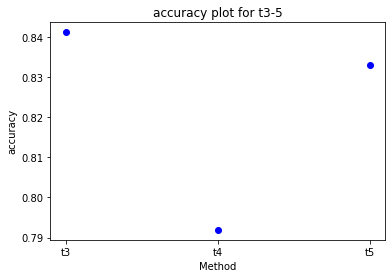

In [124]:
from matplotlib import pyplot
pyplot.title('accuracy plot for t3-5')
x = ['t3','t4','t5']
y = [acc1,acc2,acc3]
pyplot.xlabel('Method')
pyplot.ylabel('accuracy')
pyplot.plot(x,y,'ob')
pyplot.show()

From the plot we can conclude that the t3 bayesian network has the highest average acc,since it has complete information of the dependency relationship.The average accuarcy rate of t5 tree-argumented naive bayes(TAN) is slightly fall behind, around 83.TAN method uses mutual information to dig inner relationship behind data so that we can build bayesian graph with data.Naive bayes of t4 gives us the lowest average acc,below 80 percent.This result is easy to predict since it only needs data and takes the class_var(BC) as the root node pointing to every other nodes(except Metastasis and LymphNodes),so it loses information of dependency within data.
Also because of the long time doing t5 cv part,we also want to take record of the time spent on t3,t4,t5 on the laptop(macbook pro 2.2GHz i7 processor and 16GB memory) .The plot revealing time of computing t3,t4,t5 on this laptop is shown as the following code.

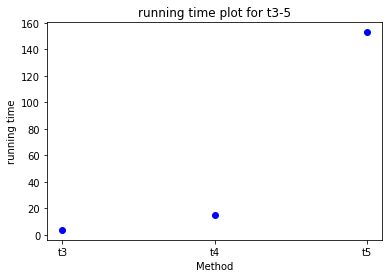

In [125]:
pyplot.title('running time plot for t3-5')
x = ['t3','t4','t5']
y = [time_t3,time_t4,time_t5]
pyplot.xlabel('Method')
pyplot.ylabel('running time')
pyplot.plot(x,y,'ob')
pyplot.show()

From the running time plot we can see the task3 bayesian network runs fastest, less than 5 seconds.The naive bayes model also get quick result with less than 20 seconds.But task5 TAN method runs really slow,around 160s to get final 10-fold cross validation result,the reason of which is the enormous time spent on computing MI among nodes and do the full joint table.After writing code to test the time on each part of t5(the code does not show on the report since it is messy),we find each time generating tree graph is about 6s and getting full joint table is about 9s on the laptop.This two parts really dominate complexity and we can not find out way to refine it.

b: The complexity of the implemented algorithms for the five tasks.

task1: the time and space complexity of D-separation is O(EN),where E is the number of edges of graph and N is the number of graph nodes,it is easy to conclude this since the time and space of this procedure are linear in the size of the DAG.

task2: the time of the learn outcome step is O(S),where S is the number of columns of data.While the space complexity is O(SO) with S the number of columns of data and O the number of outcome of each column.
The time and space complexity of learn table function is O(N$O^{E}$),where N is the number of node of graph,O is the maximum number among all the outcome of each column,E is the maximum number of edges incomming to one node.

task3: the time for assessing accuracy of the test set is O($P^{E}$+TO),where P is the maximum rows of CPT of all the outgoing nodes of class_var(BC), E is the number of outgoing nodes of BC,T is the total number of test set,O is the number of outcome of class_var,for the graph of task3,the impact of exponential growth is relatively slow since E is only a small subset of the whole graph.The space complexity is O($P^{E}$),the varible defination i are just as previous one.
The cv part time complexity is O(K($P^{E}$+TO)),where K is k-fold cross validation and here is 10,the rest parameters are same as before.Space complexity is O($P^{E}$ + T),where T is total number of data,the rests are the same meaning.

task4: the time complexity of assessing accuracy is O(TOE),where T is total number of rows of data,O is the number of outcome of class_var and E is the number of outgoing nodes of BC.It is O(1) space complexity for this function.
Learn naive bayes is O(1) time complexity and O(N) space complexity,where N is number of nodes.
CV part time complexity is O(KTOE),where K is k-fold cross validation and here is 10,the rest TOE is the same as assessing accuracy.

task5: the time complexity of learning tan structure is O($N^{2}$$O^{3}$),where N is the number of nodes except class_var,Metastasis,LymphNodes and O is the maximum number of outcome among these nodes.The reason is because the time is dominated by the computing mutual information part.The space complexity is O($N^{2}$),N is the defination as previous one.  
the time complexity of CV part is O(K($N^{2}$$O^{3}$+$P^{E}$+TO)),the defination of parameters is the same as t3 cv part and the learning tan part.This time since class_var points to every node, E becomes larger, so joining tables part grows exponationally and thus it takes so much time to do this part.Space complexity is about O($N^{2}$+$P^{E}$+T),same meaning as before.

